In [1]:
# FIXME: don't do this
import sys; sys.path.append('..')

## The color of roads

A problem facing the road surface classifier is the proper segmentation of the road in the image from other confusers: mainly vegetation. Luckily for us, roads tend to be a certain set of colors, and vegetation tends to be another set of colors. We can leverage this create a segmentation approach that can identify where the road is, and filter out obscuring foliage.

This approach will allow our segmentation model to understand the difference between the color of a road and the resulting background. Additionally, our classification model will be able to provide an estimation of how obscured the road is in a given image. This information is extraordinately useful as a means to express confidence in our classification result.

To support this analysis, I have gone through ~1000 road sample chips and labeled them by obscuration level, a scale of the road visibility. The values are as follows:

| Obscuration  |        Meaning             |
| ------------ | -------------------------- |
| -1           | Unlabeled data             |
| 0            | Unobscured                 |
| 1            | ~ 33% obscured             |
| 2            | ~ 67% obscured             |
| 3            | Nearly completely obscured |

I also included a `bad_detect` annotation such that we can filter imagery in which the OSM way matches up with the NAIP image nicely. Here we load as `pos_df` and `neg_df`, which are chips we will use for positive and negative color samples, respectively.

In [8]:
import sqlite3
import pandas as pd
from IPython.display import display

# Connect to sqlite database
with sqlite3.connect('file:/data/road_surface_classifier/features.sqlite3?mode=ro', uri=True) as con:
    cursor = con.cursor()

    # Get all truthed roadways with next-to-no obscuration that are valid
    cursor.execute("""
        SELECT osm_id, chip_path from features
        WHERE obscuration != -1 AND obscuration <= 1 AND no_data = 0 and bad_detect = 0
        GROUP BY chip_path HAVING COUNT(*) == 1;
    """)
    pos_rows = cursor.fetchall()

    # Get all truthed roadways with next-to-complete obscuration that are valid
    cursor = con.cursor()
    cursor.execute("""
        SELECT osm_id, chip_path from features
        WHERE obscuration != -1 AND obscuration == 3 AND no_data = 0 and bad_detect = 0
        GROUP BY chip_path HAVING COUNT(*) == 1;
    """)
    neg_rows = cursor.fetchall()

# Put this all in a dataframe
pos_df = pd.DataFrame(pos_rows, columns=['osm_id', 'chip_path']).set_index('osm_id')
neg_df = pd.DataFrame(neg_rows, columns=['osm_id', 'chip_path']).set_index('osm_id')

# Load OSM features and extract WKT values for the OSM IDs from above
osm_df = pd.read_csv('/data/road_surface_classifier/features.csv')

# Combine this with our original DataFrame to get a "super-duper" DataFrame with wkt values
pos_df = pd.concat([pos_df, osm_df.set_index('osm_id').loc[pos_df.index]['wkt']], axis=1)
neg_df = pd.concat([neg_df, osm_df.set_index('osm_id').loc[neg_df.index]['wkt']], axis=1)
display(pos_df)
display(neg_df)

,chip_path,wkt
osm_id,,
1000804590,/data/road_surface_classifier/imagery/10008045...,"LINESTRING (-95.5572233 29.7098035,-95.5572269..."
1005086973,/data/road_surface_classifier/imagery/10050869...,"LINESTRING (-73.727361 41.228755,-73.726615 41..."
10062629,/data/road_surface_classifier/imagery/10062629...,"LINESTRING (-97.1195594 32.7515292,-97.1232604..."
10104745,/data/road_surface_classifier/imagery/10104745...,"LINESTRING (-112.0564806 37.5358296,-112.05677..."
10105788,/data/road_surface_classifier/imagery/10105788...,"LINESTRING (-109.2941603 38.8600777,-109.29438..."
...,...,...
9923837,/data/road_surface_classifier/imagery/9923837.tif,"LINESTRING (-99.7169109 44.548138,-99.7169039 ..."
993076250,/data/road_surface_classifier/imagery/99307625...,"LINESTRING (-84.0206876 41.7834173,-84.0206981..."
994986166,/data/road_surface_classifier/imagery/99498616...,"LINESTRING (-78.3404717 43.2359061,-78.3404799..."


,chip_path,wkt
osm_id,,
1011552973,/data/road_surface_classifier/imagery/10115529...,"LINESTRING (-80.4775304 41.4970932,-80.4774311..."
1024597156,/data/road_surface_classifier/imagery/10245971...,"LINESTRING (-70.5445261 41.5594261,-70.5445925..."
1024947845,/data/road_surface_classifier/imagery/10249478...,"LINESTRING (-71.9895984 42.3209293,-71.9896377..."
1056789398,/data/road_surface_classifier/imagery/10567893...,"LINESTRING (-73.1663723 41.7151124,-73.1663074..."
10721164,/data/road_surface_classifier/imagery/10721164...,"LINESTRING (-76.819171 41.9765929,-76.819083 4..."
...,...,...
952531867,/data/road_surface_classifier/imagery/95253186...,"LINESTRING (-82.9412381 34.9470773,-82.9412772..."
972682704,/data/road_surface_classifier/imagery/97268270...,"LINESTRING (-80.0585096 34.3251579,-80.0585583..."
974134725,/data/road_surface_classifier/imagery/97413472...,"LINESTRING (-72.3935871 41.5494337,-72.3936287..."


To visualize this data, let's take a quick sample of unobscured (positive) and unobscured (negative) samples.

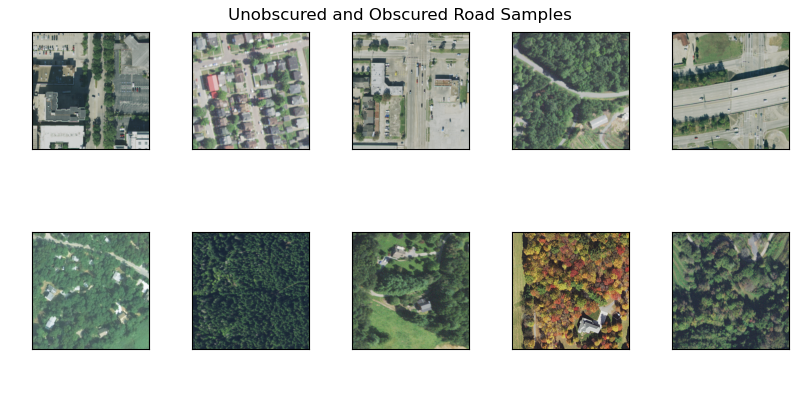

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

# Take a random sample
n = 5
pos_s = pos_df.sample(n=n, random_state=1234)
neg_s = neg_df.sample(n=n, random_state=1234)

# Plot the samples
fig, ax = plt.subplots(2, n, figsize=(8, 4))
fig.tight_layout(pad=0)
fig.suptitle('Unobscured and Obscured Road Samples')

# Plot positive samples (unobscured)
for idx, ax_ in enumerate(ax[0]):
    im_path = pos_s.iloc[idx]['chip_path']
    im = np.array(PIL.Image.open(im_path))
    ax_.imshow(im[..., :3])

# Plot negative samples (nearly completely obscured)
for idx, ax_ in enumerate(ax[1]):
    im_path = neg_s.iloc[idx]['chip_path']
    im = np.array(PIL.Image.open(im_path))
    ax_.imshow(im[..., :3])

# Hide axis labels for plotted imagert
for ax_ in ax.flatten():  # type: ignore
    ax_.get_xaxis().set_visible(False)
    ax_.get_yaxis().set_visible(False)

# Delete samples
del n, pos_s, neg_s

Define a function `create_mask` that can generate a binary mask of a given width of the OSM way in the geospatial reference of each image chip.

In [4]:
from osgeo import ogr, osr
ogr.UseExceptions()

import PIL.Image
import PIL.ImageDraw

from data_prep.utils import imread, imread_srs, imread_geotransform, map_to_pix

# Standard WGS-84 spatial reference
srs_ref = osr.SpatialReference()
srs_ref.ImportFromEPSG(4326)
srs_ref.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)

def create_mask(row, width=2):    
    # Get list of points from WKT
    geom = ogr.CreateGeometryFromWkt(row['wkt'])
    pts = np.array(
        [geom.GetPoint_2D(idx) for idx in range(geom.GetPointCount())])
    lon_ar, lat_ar = pts[:, 0], pts[:, 1]

    # Get the image's geotransform
    xform = imread_geotransform(row['chip_path'])

    # Get the spatial reference (they change across the tiles)
    srs = osr.SpatialReference()
    srs.ImportFromProj4(imread_srs(row['chip_path']))
    srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    im_trans = osr.CoordinateTransformation(srs_ref, srs)

    # Get list of points from WKT
    geom: ogr.Geometry = ogr.CreateGeometryFromWkt(row['wkt'])
    geom.Transform(im_trans)
    pts = np.array(
        [geom.GetPoint_2D(idx) for idx in range(geom.GetPointCount())])

    # Convert to image-space x, y
    ix, iy = map_to_pix(xform, pts[:, 0], pts[:, 1])  # type: ignore

    # Load image
    im = imread(row['chip_path'])

    # Create a new image of the same shape, and draw a line
    # to create a mask
    mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
    mask_pil = PIL.Image.new('L', ((im.shape[1], im.shape[0])), color=0)
    d = PIL.ImageDraw.Draw(mask_pil)
    d.line(
        [(x, y) for x, y in zip(ix, iy)],     # type: ignore
        fill=255,
        width=width, # Original: 10,
        joint="curve")
    mask = np.array(mask_pil)
    return im, mask

Define a function `avg_color`, in which, given an image chip and mask, we will fetch the road's color and convert it to [CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space) (somewhat perceptually uniform) space. The reason for this conversion is that distance between colors in this space has a more relevant meaning than RGB colors. In the end, this will give us a list of colors in a $(\mathrm{NIR}, L, a, b)$ (NIR = near-infrared) latent space. Finally, the geometric median of the road color points in this latent space will be computed and returned.

In [5]:
import skimage.color
from data_prep.geometric_median import geometric_median

def avg_color(im, mask):
    im_where = im[np.where(mask)]
    im_irlab = np.hstack((
        im_where[..., (3,)] * (100.0 / 255),
        skimage.color.rgb2lab(im_where[..., (0, 1, 2)]).reshape((-1, 3))))
    avg_color_irlab = geometric_median(im_irlab)
    return avg_color_irlab


This code will give us an approximately even number of positive and negative road color samples.
- The positive samples are found using the geometric median approach described above.
- Negative samples are generated by sampling a random set of points in an image in which a road is completely obscured. This is a pretty-fair approach of sampling colors that are (most likely) not part of a road.

In [6]:
%matplotlib widget

from tqdm import tqdm

pos_sample_list = []
neg_sample_list = []

for idx in tqdm(range(len(pos_df))):
    row = pos_df.iloc[idx]
    
    # Gen positive sample
    im, mask = create_mask(row, width=2)
    pos_avg = avg_color(im, mask)
    pos_sample_list.append(pos_avg)

for idx in tqdm(range(len(neg_df))):
    row = neg_df.iloc[idx]
    
    # Get negative samples
    im, _ = create_mask(row, width=2)
    for _ in range(len(pos_df) // len(neg_df)):
        y, x = np.floor(np.random.random((2,)) * 256).astype(int)
        nir = im[y, x, 3] * (100.0 / 255)
        lab = skimage.color.rgb2lab(im[y, x, (0, 1, 2)])
        neg_sample_list.append((nir, *lab))


pos_sample_list = np.array(pos_sample_list)
neg_sample_list = np.array(neg_sample_list)

100%|██████████| 75/75 [00:00<00:00, 212.93it/s]


Our color samples are in a 4-dimensional latent space, but we will visualize the resulting positive and negative sample point clouds in CIELAB $a$- and $b$- space, which are the dimensions of color that the human eye percieves and neglects luminosity and the NIR response.

The separability between these point clouds is evident.

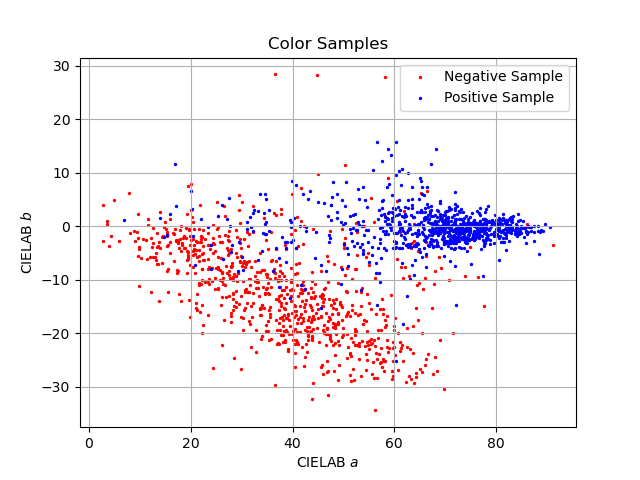

In [35]:
%matplotlib widget

fig, ax = plt.subplots()
ax.scatter(neg_sample_list[:, 1], neg_sample_list[:, 2], 2, color='r')  # type: ignore
ax.scatter(pos_sample_list[:, 1], pos_sample_list[:, 2], 2, color='b')  # type: ignore
ax.set_xlabel('CIELAB $a$')
ax.set_ylabel('CIELAB $b$')
ax.set_title('Color Samples')
ax.grid()
ax.legend(('Negative Sample', 'Positive Sample'))

In [41]:
# Prepare training set
X = np.vstack((pos_sample_list, neg_sample_list))
y = np.concatenate(([0] * len(pos_sample_list), [1] * len(neg_sample_list)))
np.savez('color_dataset.npz', X=X, y=y)